In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import torchshow as ts
from datasets.nerf_synthetic import SubjectLoader
from nerfacc.estimators.occ_grid import OccGridEstimator
from radiance_fields.ngp_single_mlp import NGPRadianceFieldSingleMlp
from typing import Any, Dict
from utils import render_image_with_occgrid_test

device = "cuda:2"

# dataset parameters
scene = "chair"
data_root = "/media/data7/fballerini/datasets/nerf_synthetic"
test_dataset_kwargs = {}
# scene parameters
aabb = torch.tensor([-1.5, -1.5, -1.5, 1.5, 1.5, 1.5], device=device)
near_plane = 0.0
far_plane = 1.0e10
# model parameters
grid_resolution = 128
grid_nlvl = 1
# render parameters
render_step_size = 5e-3
alpha_thre = 0.0
cone_angle = 0.0

test_dataset = SubjectLoader(
    subject_id=scene,
    root_fp=data_root,
    split="test",
    num_rays=None,
    device=device,
    **test_dataset_kwargs,
)

estimator = OccGridEstimator(
    roi_aabb=aabb, 
    resolution=grid_resolution, 
    levels=grid_nlvl
).to(device)
radiance_field = NGPRadianceFieldSingleMlp(
    aabb=estimator.aabbs[-1],
    use_viewdirs=False,
    base_resolution=32,
    n_levels=1,
    n_features_per_level=8,
    encoding_type="torch",
    mlp_activation="Sine",
    n_neurons=64,
    n_hidden_layers=3
).to(device)

In [2]:
def render_test(state_dict: Dict[str, Any], index: int = 50) -> float:
    estimator.load_state_dict(state_dict["estimator"])
    radiance_field.load_state_dict(state_dict["radiance_field"])

    # evaluation
    radiance_field.eval()
    estimator.eval()

    with torch.no_grad():
        data = test_dataset[index]
        render_bkgd = data["color_bkgd"]
        rays = data["rays"]
        pixels = data["pixels"]

        # rendering
        rgb, _, _, _ = render_image_with_occgrid_test(
            1024,
            # scene
            radiance_field,
            estimator,
            rays,
            # rendering options
            near_plane=near_plane,
            render_step_size=render_step_size,
            render_bkgd=render_bkgd,
            cone_angle=cone_angle,
            alpha_thre=alpha_thre,
        )
        mse = F.mse_loss(rgb, pixels)
        psnr = -10.0 * torch.log(mse) / np.log(10.0)
        
        ts.show(rgb)
        return psnr.item()

# Voxel grid $32 \times 32 \times 8$

## $(V_A,M_A)$

25.989322662353516

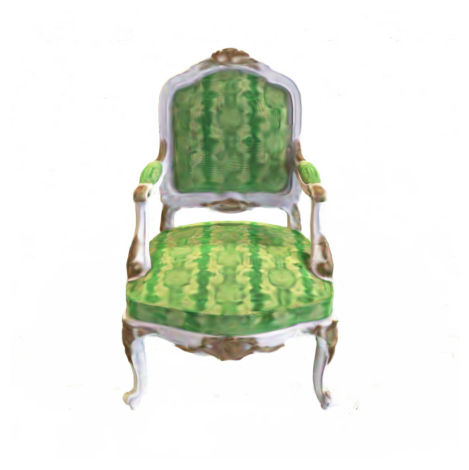

In [4]:
sd_A = torch.load("ckpts/torch_sine_single_1_8_32/chair_A.pt")

render_test(sd_A)

## $(V_A,M_B)$

13.864606857299805

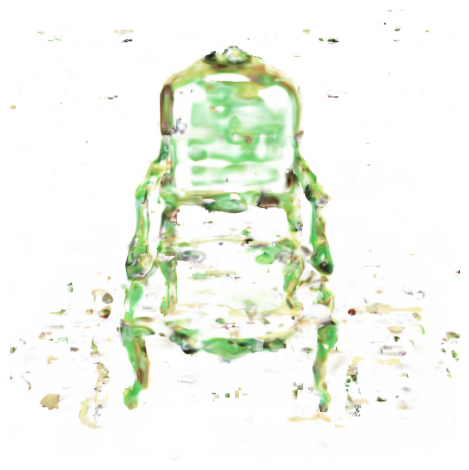

In [5]:
sd_A = torch.load("ckpts/torch_sine_single_1_8_32/chair_A.pt")
sd_B = torch.load("ckpts/torch_sine_single_1_8_32/chair_B.pt")
sd_A["radiance_field"]["mlp.params"] = sd_B["radiance_field"]["mlp.params"]

render_test(sd_A)

## $(V_A^\text{perm},M_B)$

17.725780487060547

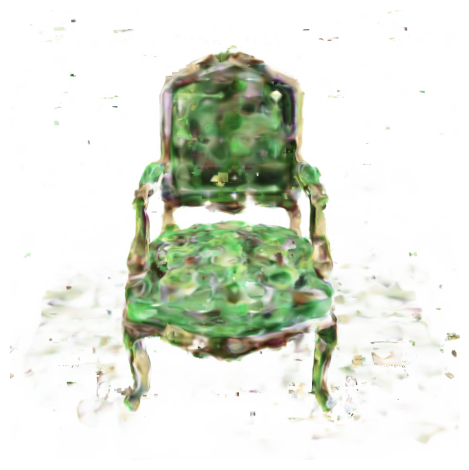

In [7]:
sd = torch.load("ckpts/torch_sine_single_1_8_32/chair_perm.pt")

render_test(sd)

# Voxel grid $32 \times 32 \times 4$

In [5]:
radiance_field = NGPRadianceFieldSingleMlp(
    aabb=estimator.aabbs[-1],
    use_viewdirs=False,
    base_resolution=32,
    n_levels=1,
    n_features_per_level=4,
    encoding_type="torch",
    mlp_activation="Sine",
    n_neurons=64,
    n_hidden_layers=3
).to(device)

## $(V_A,M_A)$

24.931886672973633

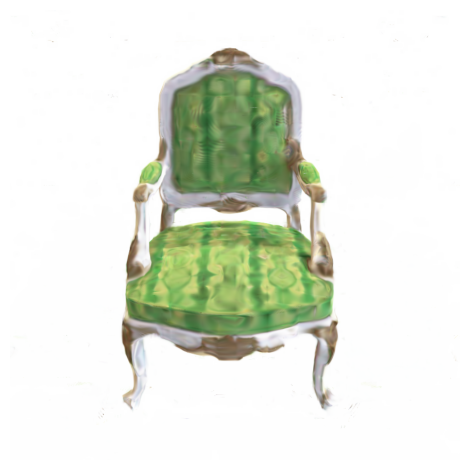

In [6]:
sd_A = torch.load("ckpts/torch_sine_single_1_4_32/chair_A.pt")

render_test(sd_A)

## $(V_A,M_B)$

11.924647331237793

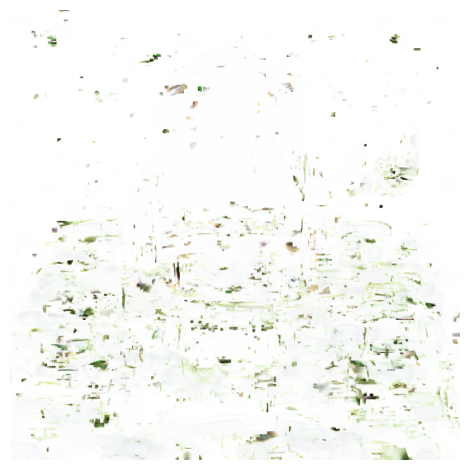

In [7]:
sd_A = torch.load("ckpts/torch_sine_single_1_4_32/chair_A.pt")
sd_B = torch.load("ckpts/torch_sine_single_1_4_32/chair_B.pt")
sd_A["radiance_field"]["mlp.params"] = sd_B["radiance_field"]["mlp.params"]

render_test(sd_A)

## $(V_A^\text{perm},M_B)$

16.12734603881836

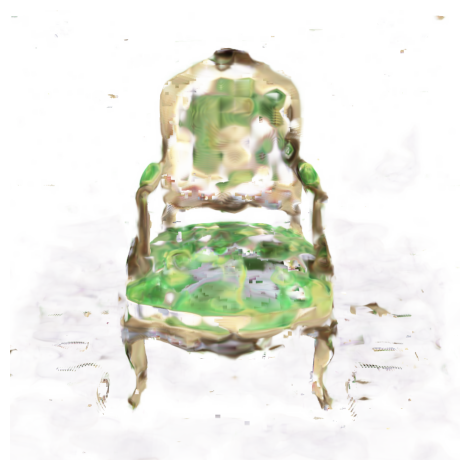

In [8]:
sd = torch.load("ckpts/torch_sine_single_1_4_32/chair_perm.pt")

render_test(sd)